In [1]:
import pandas as pd 
import json
from pathlib import Path
import pathlib
import os

## Load data from data folder

In [2]:
# find basepath
data_path = Path(".").resolve()
while True:
    if "data" in [p.name for p in data_path.iterdir()]:
        break
    data_path = data_path.parent
data_path = data_path / "data"

In [3]:
positive_data_path = data_path / "positive_samples" / "positive_samples_v2_170221_corrected_journals_removed_tags.pd.json"
neg_matched_data_zip_path = data_path / "negative_samples" / "cleaned_negative_data_from_comparable_volumes.zip"
neg_random_data_zip_path = data_path / "negative_samples" / "random_journal_metadata.zip"
journal_usage_freq_path = data_path / "journal_data" / "journal_usage_frequency.pd.json"

In [4]:
neg_random_data = pd.read_json(neg_random_data_zip_path, compression="zip")
journal_usage_freq = pd.read_json(journal_usage_freq_path)
positive_data = pd.read_json(positive_data_path)
data = pd.read_json(neg_matched_data_zip_path).to_dict()
journal_name_to_neg_article_df = {}
for key in data.keys():
    journal_name_to_neg_article_df[key] = pd.DataFrame.from_dict(data[key])
del data

## Extract relevant columns + standardize column names

In [5]:
# Rename Columns
neg_data_rename = {"year":"publication_date", "paperAbstract": "abstract", "journalName" : "journal_name"}
neg_random_data = neg_random_data.rename(columns=neg_data_rename)

for journal_name, df in journal_name_to_neg_article_df.items():
    journal_name_to_neg_article_df[journal_name] = df.rename(columns=neg_data_rename)

#Take subset of data we care about
pos_data_subset = ["title", "doi", "publication_date", "abstract", "journal_name", "topic_classification"]
neg_data_subset = ["title", "doi", "publication_date", "abstract", "journal_name", "topic_classification"]

neg_random_data = neg_random_data.assign(topic_classification = None)

positive_data = positive_data.loc[:, pos_data_subset]
neg_random_data = neg_random_data.loc[:, neg_data_subset]
for journal_name, df in journal_name_to_neg_article_df.items():
    journal_name_to_neg_article_df[journal_name] = df.assign(topic_classification = None).loc[:, neg_data_subset]

Add column Relevance!

In [6]:
positive_data.loc[:, "relevance"] = 1
neg_random_data.loc[:, "relevance"] = 0
for journal_name, df in journal_name_to_neg_article_df.items():
    df.loc[:, "relevance"] = 0

## Split into Test, Train, Validation

### Part I: Get Sampling distribution for matched negative data -- Smooth original distribution

Data shown is journal vs likelihood of being sampled

In [7]:
import matplotlib.pyplot as plt 
import numpy as np

journal_weights = journal_usage_freq.to_dict()["counts"]
del journal_weights[""]

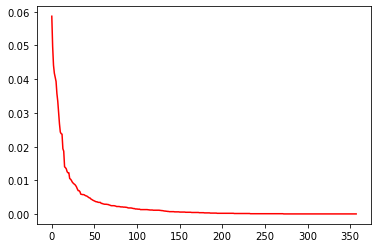

In [8]:
journal_dist = np.array(list(journal_weights.values()))
journal_dist = np.sort(journal_dist)[::-1] / np.sum(journal_dist)
plt.plot(journal_dist, color="red")

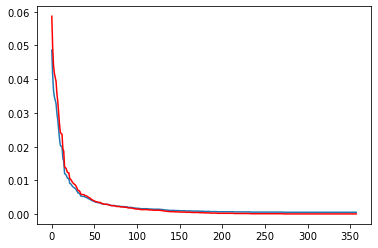

In [9]:
def laplace_smooth_journal_weights(weights_dict, alpha = 10.0):
    standard_weighted_dict = {}
    N = sum(weights_dict.values())
    D = len(weights_dict)
    for key, val in weights_dict.items():
        standard_weighted_dict[key] = (alpha + val) / (N + alpha*D)
    return standard_weighted_dict

smooth_journal_dist = laplace_smooth_journal_weights(journal_weights)
sm_journ_ls = list(reversed(sorted([v for _,v in smooth_journal_dist.items()])))
plt.plot(sm_journ_ls)
plt.plot(journal_dist, color="red")
plt.show()

### Step II: Decide on size of different samples

Data Size: 20k pos, 300k neg rand, 368k neg close rand

We wish to use all positive data, because it is our best datapoint -- Hence all other parts will be relative to the positive samples!

In [14]:
import math
pos_samples = len(positive_data.loc[pd.isna(positive_data["abstract"])==False, :])
num_neg_random_samples = pos_samples * 5
num_neg_matched_samples = pos_samples * 4

neg_matched_samples_per_journal = {}
for key, val in smooth_journal_dist.items():
    neg_matched_samples_per_journal[key] = math.ceil(val*num_neg_matched_samples)

### Step III: Sample and Concatenate

In [15]:
total_data = pd.DataFrame(columns=pos_data_subset)
to_concat = [positive_data.loc[pd.isna(positive_data["abstract"])==False, :], neg_random_data.sample(n=num_neg_random_samples)]

for key, df in journal_name_to_neg_article_df.items():
    to_concat.append(df.sample(n=min(len(df), neg_matched_samples_per_journal[key])))

In [16]:
total_data = pd.concat(to_concat)

In [17]:
total_data = total_data.sample(frac=1)

In [18]:
total_data.reset_index(inplace=True, drop=True)

In [19]:
data_folder = Path(".") /"ml_data"

Combine Data aprropriately

In [20]:
x_relevance_data_v1 = total_data.loc[:, ["title", "doi", "publication_date", "abstract", "journal_name", "topic_classification"]]
y_relevance_data_v1 = pd.DataFrame(total_data.loc[:, "relevance"])

In [21]:
x_relevance_data_v1.to_json(data_folder / "x_relevance_data_v1.pd.json")
y_relevance_data_v1.to_json(data_folder / "y_relevance_data_v1.pd.json")

In [22]:
positive_data = positive_data.loc[pd.isna(positive_data["abstract"])==False, :] 
positive_data.reset_index(drop=True, inplace=True)
x_classification_pos_data_v1 = positive_data.loc[:, ["title", "doi", "publication_date", "abstract", "journal_name"]]
y_classification_pos_data_v1 = positive_data.loc[:, ["topic_classification"]]

In [23]:
x_classification_pos_data_v1.to_json(data_folder / "x_classification_pos_data_v1.pd.json")
y_classification_pos_data_v1.to_json(data_folder / "y_classification_pos_data_v1.pd.json")